###  Step 1: Installation & Setup

In [1]:
import torch
import torchhd as hd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

###  Step 3: Compression (Clamping)

#### (a) Memory Robustness

(i) Vary with respect to the number of memorized patterns p

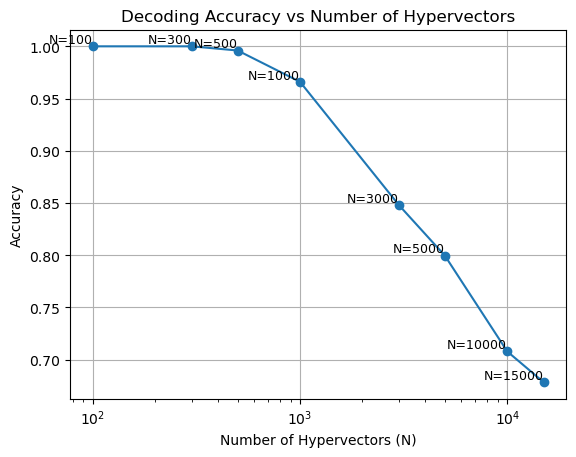

In [7]:
D = 10000
N = [100,300,500,1000,3000,5000,10000,15000]

results = {}


for n in N:
    codebook = hd.random(n, D)
    bundle_hv = codebook[0]
    
    # Bundle half of the hypervectors
    for i in range(1, n//2):
        bundle_hv = hd.bundle(bundle_hv, codebook[i])
    #Compress the bundle
    bundle_hv = torch.clamp(bundle_hv, min=-1, max=1)
    memorized_similarities = []
    not_memorized_similarities = []

    # Compute similarities
    for i in range(n):
        similarity = hd.dot_similarity(bundle_hv, codebook[i]).item()
        if i < n//2:
            memorized_similarities.append(similarity)
        else:
            not_memorized_similarities.append(similarity)

    # Use the midpoint between memorized and not memorized
    threshold = (np.mean(memorized_similarities) + np.mean(not_memorized_similarities)) / 2

    correct = 0
    for i in range(n):
        similarity = hd.dot_similarity(bundle_hv, codebook[i])
        if (i < n//2 and similarity > threshold) or (i >= n//2 and similarity <= threshold):
            correct += 1

    accuracy = correct / n
    results[n] = accuracy

# Plotting results
N_val = list(results.keys())
accuracies = [results[n] for n in N_val]

plt.plot(N_val, accuracies, marker='o', label=f'D={D}')
for n, acc in zip(N_val, accuracies):
    plt.text(n, acc, f'N={n}', fontsize=9, ha='right', va='bottom')

plt.xscale('log')
plt.xlabel('Number of Hypervectors (N)')
plt.ylabel('Accuracy')
plt.title('Decoding Accuracy vs Number of Hypervectors')
plt.grid(True)
plt.show()


(ii) vary with the hyperdimension D and the magnitude of the noise

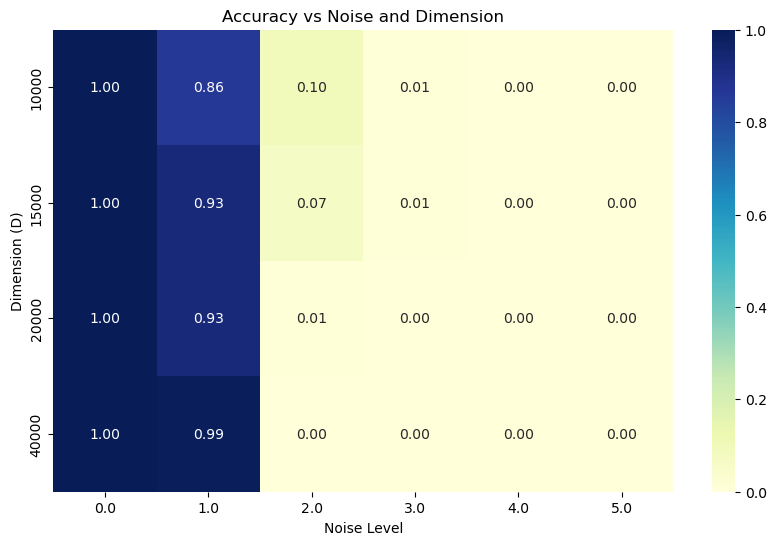

In [15]:
D = [10000,15000,20000,40000]
N = 200
p = N//2
noise = [0.0,1.0,2.0,3.0,4.0,5.0]
results = np.zeros((len(D), len(noise)))



for i, d in enumerate(D):
    codebook = hd.random(N, d)
    bundle_hv = codebook[0]

    for j in range(1, p):
        bundle_hv = hd.bundle(bundle_hv, codebook[j])

    #Clamping the bundled hypervector after bundling
    bundle_hv = torch.clamp(bundle_hv, min=-1, max=1)

    # Compute similarity scores for thresholding
    memorized_similarities = []
    not_memorized_similarities = []

    for k in range(N):
        similarity = hd.dot_similarity(bundle_hv, codebook[k]).item()
        if k < p:
            memorized_similarities.append(similarity)
        else:
            not_memorized_similarities.append(similarity)

    # Compute the adaptive threshold
    threshold = (np.mean(memorized_similarities) + np.mean(not_memorized_similarities)) / 2

    for j, n in enumerate(noise):
        correct = 0
        for k in range(p):
            # Add noise to the hypervector
            noisy_hv = codebook[k] + torch.normal(0, n, size=codebook[k].size())

            # Clamping the noisy hypervector after adding noise
            noisy_hv = torch.clamp(noisy_hv, min=-1, max=1)

            similarity = hd.dot_similarity(bundle_hv, noisy_hv)

            if (k < p and similarity > threshold) or (k >= p and similarity <= threshold):
                correct += 1

        accuracy = correct / p
        results[i, j] = accuracy

# Plotting results
plt.figure(figsize=(10, 6))
sns.heatmap(results, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=noise, yticklabels=D)
plt.xlabel('Noise Level')
plt.ylabel('Dimension (D)')
plt.title('Accuracy vs Noise and Dimension')
plt.show()




#### (b) Memory Capacity

(i)Vary with the hyperdimension D

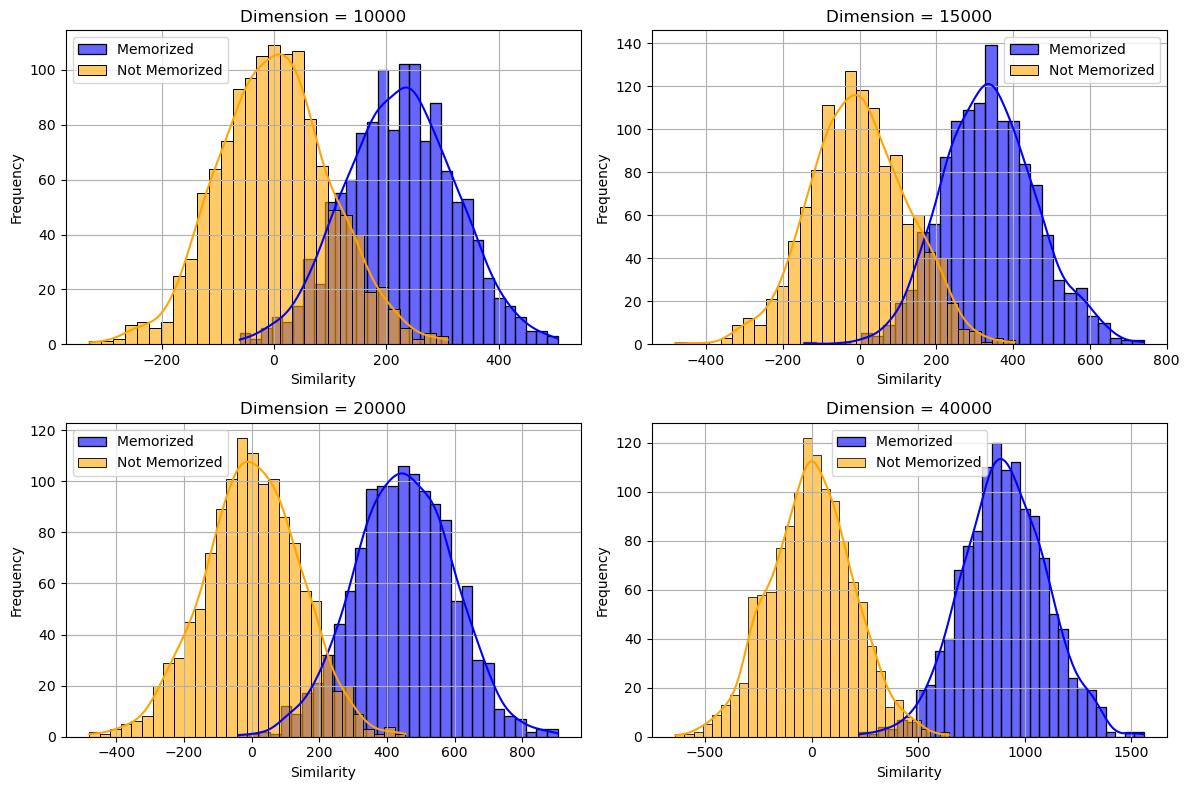

In [10]:
D = [10000,15000,20000,40000]
N = 2500

results = {}

for d in D:
    codebook = hd.random(N, d)
    bundle_hv = codebook[0]
    for i in range(1, N//2):
        bundle_hv = hd.bundle(bundle_hv, codebook[i])
    bundle_hv = torch.clamp(bundle_hv, min=-1, max=1)
    memorized = []
    not_memorized = []
    for i in range(len(codebook)):
        similarity = hd.dot_similarity(bundle_hv, codebook[i])
        if i < len(codebook)//2:
            memorized.append(similarity.item())
        else:  
            not_memorized.append(similarity.item())
    results[d] = (memorized, not_memorized)
# Plotting the results

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes = axes.flatten()

# Iterate through different dimensions and plot histograms
for idx, (d, (memorized, not_memorized)) in enumerate(results.items()):
    ax = axes[idx]
    
    # Plot distributions for memorized and not memorized items
    sns.histplot(memorized, color='blue', label='Memorized ', kde=True, bins=30, alpha=0.6, ax=ax)
    sns.histplot(not_memorized, color='orange', label='Not Memorized', kde=True, bins=30, alpha=0.6, ax=ax)
    
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Dimension = {d}')
    ax.legend()
    ax.grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()


(ii)Vary with the size of the symbol set n

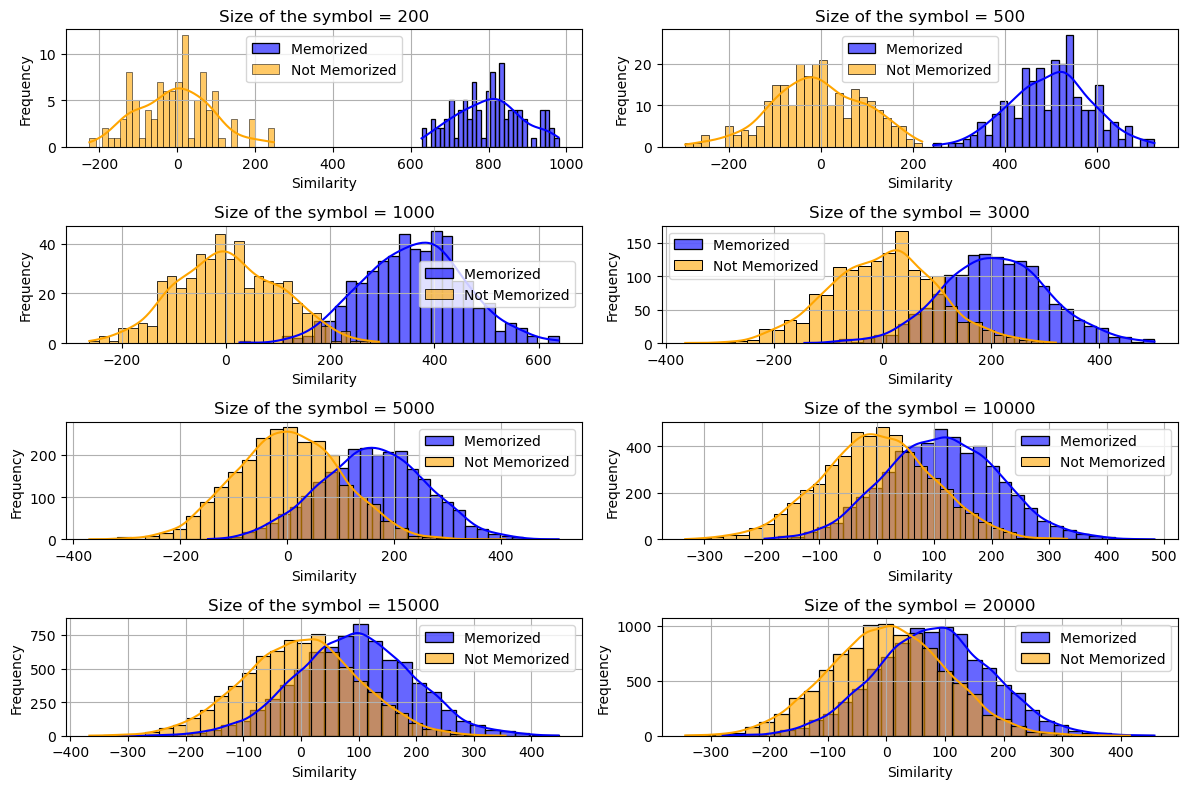

In [11]:
D =10000
N = [200,500,1000,3000,5000,10000,15000,20000]

results = {}

for n in N:
    codebook = hd.random(n, D)
    bundle_hv = codebook[0]
    for i in range(1, n//2):
        bundle_hv = hd.bundle(bundle_hv, codebook[i])
    bundle_hv = torch.clamp(bundle_hv, min=-1, max=1)
    memorized = []
    not_memorized = []
    for i in range(len(codebook)):
        similarity = hd.dot_similarity(bundle_hv, codebook[i])
        if i < len(codebook)//2:
            memorized.append(similarity.item())
        else:  
            not_memorized.append(similarity.item())
    results[n] = (memorized, not_memorized)
# Plotting the results
fig, axes = plt.subplots(4, 2, figsize=(12, 8))

axes = axes.flatten()

# Iterate through different size of symbol and plot histograms
for idx, (n, (memorized, not_memorized)) in enumerate(results.items()):
    ax = axes[idx]
    
    # Plot distributions for memorized and not memorized items
    sns.histplot(memorized, color='blue', label='Memorized ', kde=True, bins=30, alpha=0.6, ax=ax)
    sns.histplot(not_memorized, color='orange', label='Not Memorized', kde=True, bins=30, alpha=0.6, ax=ax)
    
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Size of the symbol = {n}')
    ax.legend()
    ax.grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()